# This notebook predicts the outcome of UFC fights

In [1]:
import pandas as pd
import numpy as np
pd.options.display.max_colwidth = 100

pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

In [2]:
ufc_data = pd.read_csv("ufc_data.csv")

In [3]:
ufc_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7294 entries, 0 to 7293
Data columns (total 52 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Fighter A      7294 non-null   object 
 1   Fighter B      7294 non-null   object 
 2   Result         7294 non-null   object 
 3   Weightclass    7294 non-null   float64
 4   Rounds         7294 non-null   int64  
 5   Venue          7294 non-null   object 
 6   Date           7294 non-null   object 
 7   Location       7294 non-null   object 
 8   Billing        7294 non-null   object 
 9   Event Name     7294 non-null   object 
 10  Referee        7192 non-null   object 
 11  Description    7265 non-null   object 
 12  Method         7294 non-null   object 
 13  Finish         7294 non-null   int64  
 14  Odds A         7294 non-null   int64  
 15  Title A        328 non-null    object 
 16  Weight A       7294 non-null   float64
 17  Age A          7294 non-null   int64  
 18  Height A

First we need to modify the data to suit prediction models.

To make no impact on who fighter A and B is we need to copy all data, switch sides and result and concatenate new data to existing data.

In [4]:
ufc_copy = ufc_data.copy()

In [5]:
ufc_copy.columns=['Fighter B', 'Fighter A', 'Result', 'Weightclass', 'Rounds', 'Venue',
       'Date', 'Location', 'Billing', 'Event Name', 'Referee', 'Description',
       'Method', 'Finish', 'Odds B', 'Title B', 'Weight B', 'Age B',
       'Height B', 'Reach B', 'KO win B', 'KO loss B', 'Sub win B',
       'Sub loss B', 'Dec win B', 'Dec loss B', 'Draws B', 'UFC win B',
       'UFC loss B', 'UFC draws B', 'Nationality B', 'Nick B', 'Odds cat B',
       'Odds A', 'Title A', 'Weight A', 'Age A', 'Height A', 'Reach A',
       'KO win A', 'KO loss A', 'Sub win A', 'Sub loss A', 'Dec win A',
       'Dec loss A', 'Draws A', 'UFC win A', 'UFC loss A', 'UFC draws A',
       'Nationality A', 'Nick A', 'Odds cat A']


In [6]:
ufc_copy.head()

,Fighter B,Fighter A,Result,Weightclass,Rounds,Venue,Date,Location,Billing,Event Name,Referee,Description,Method,Finish,Odds B,Title B,Weight B,Age B,Height B,Reach B,KO win B,KO loss B,Sub win B,Sub loss B,Dec win B,Dec loss B,Draws B,UFC win B,UFC loss B,UFC draws B,Nationality B,Nick B,Odds cat B,Odds A,Title A,Weight A,Age A,Height A,Reach A,KO win A,KO loss A,Sub win A,Sub loss A,Dec win A,Dec loss A,Draws A,UFC win A,UFC loss A,UFC draws A,Nationality A,Nick A,Odds cat A
0,Marcin Tybura,Tai Tuivasa,win,265.0,5,UFC Apex,2024-03-16,"Las Vegas, Nevada, United States",Main Event,UFC Fight Night: Tuivasa vs. Tybura,Herb Dean,Rear Naked Choke,Submission,1,-105,NaN,247.0,38,191.0,198.0,9,5,6,0,9,3,0,11,7,0,Poland,Tybur,Near Even,-115,NaN,265.5,31,188.0,191.0,13,3,0,2,1,1,0,8,6,0,Australia,Bam Bam,Near Even
1,Bryan Battle,Ange Loosa,NC,170.0,3,UFC Apex,2024-03-16,"Las Vegas, Nevada, United States",Co-Main,UFC Fight Night: Tuivasa vs. Tybura,Mike Beltran,Accidental Eye Poke,No Contest,0,-180,NaN,170.0,29,185.0,196.0,3,0,5,1,2,1,0,5,1,0,United States,The Butcher,Slight Favorite,150,NaN,171.0,29,178.0,188.0,5,0,1,0,4,3,0,2,1,0,"Congo, The Democratic Republic of the",The Last Ninja,Slight Underdog
2,Ovince St. Preux,Kennedy Nzechukwu,win,205.0,3,UFC Apex,2024-03-16,"Las Vegas, Nevada, United States",Main Card,UFC Fight Night: Tuivasa vs. Tybura,Mark Smith,Split,Decision,0,500,NaN,206.0,40,191.0,203.0,12,5,8,3,6,9,0,14,12,0,United States,OSP,Heavy Underdog,-700,NaN,205.0,31,196.0,211.0,8,2,1,1,3,1,0,6,4,0,United States,American Savage,Huge Favorite
3,Christian Rodriguez,Isaac Dulgarian,win,145.0,3,UFC Apex,2024-03-16,"Las Vegas, Nevada, United States",Main Card,UFC Fight Night: Tuivasa vs. Tybura,Chris Tognoni,Split,Decision,0,165,NaN,145.0,26,170.0,180.0,3,0,4,0,3,1,0,3,1,0,United States,CeeRod,Slight Underdog,-200,NaN,145.5,27,170.0,180.0,4,0,2,0,0,0,0,1,0,0,United States,The MidWest Choppa,Moderate Favorite
4,Macy Chiasson,Pannie Kianzad,win,135.0,3,UFC Apex,2024-03-16,"Las Vegas, Nevada, United States",Main Card,UFC Fight Night: Tuivasa vs. Tybura,Mark Smith,Rear Naked Choke,Submission,1,-230,NaN,135.5,32,180.0,183.0,2,1,2,1,4,1,0,6,3,0,United States,NaN,Moderate Favorite,190,NaN,136.0,32,170.0,168.0,3,1,0,2,13,4,0,5,4,0,Sweden,Banzai,Slight Underdog


In [7]:
ufc_data.head()

,Fighter A,Fighter B,Result,Weightclass,Rounds,Venue,Date,Location,Billing,Event Name,Referee,Description,Method,Finish,Odds A,Title A,Weight A,Age A,Height A,Reach A,KO win A,KO loss A,Sub win A,Sub loss A,Dec win A,Dec loss A,Draws A,UFC win A,UFC loss A,UFC draws A,Nationality A,Nick A,Odds cat A,Odds B,Title B,Weight B,Age B,Height B,Reach B,KO win B,KO loss B,Sub win B,Sub loss B,Dec win B,Dec loss B,Draws B,UFC win B,UFC loss B,UFC draws B,Nationality B,Nick B,Odds cat B
0,Marcin Tybura,Tai Tuivasa,win,265.0,5,UFC Apex,2024-03-16,"Las Vegas, Nevada, United States",Main Event,UFC Fight Night: Tuivasa vs. Tybura,Herb Dean,Rear Naked Choke,Submission,1,-105,NaN,247.0,38,191.0,198.0,9,5,6,0,9,3,0,11,7,0,Poland,Tybur,Near Even,-115,NaN,265.5,31,188.0,191.0,13,3,0,2,1,1,0,8,6,0,Australia,Bam Bam,Near Even
1,Bryan Battle,Ange Loosa,NC,170.0,3,UFC Apex,2024-03-16,"Las Vegas, Nevada, United States",Co-Main,UFC Fight Night: Tuivasa vs. Tybura,Mike Beltran,Accidental Eye Poke,No Contest,0,-180,NaN,170.0,29,185.0,196.0,3,0,5,1,2,1,0,5,1,0,United States,The Butcher,Slight Favorite,150,NaN,171.0,29,178.0,188.0,5,0,1,0,4,3,0,2,1,0,"Congo, The Democratic Republic of the",The Last Ninja,Slight Underdog
2,Ovince St. Preux,Kennedy Nzechukwu,win,205.0,3,UFC Apex,2024-03-16,"Las Vegas, Nevada, United States",Main Card,UFC Fight Night: Tuivasa vs. Tybura,Mark Smith,Split,Decision,0,500,NaN,206.0,40,191.0,203.0,12,5,8,3,6,9,0,14,12,0,United States,OSP,Heavy Underdog,-700,NaN,205.0,31,196.0,211.0,8,2,1,1,3,1,0,6,4,0,United States,American Savage,Huge Favorite
3,Christian Rodriguez,Isaac Dulgarian,win,145.0,3,UFC Apex,2024-03-16,"Las Vegas, Nevada, United States",Main Card,UFC Fight Night: Tuivasa vs. Tybura,Chris Tognoni,Split,Decision,0,165,NaN,145.0,26,170.0,180.0,3,0,4,0,3,1,0,3,1,0,United States,CeeRod,Slight Underdog,-200,NaN,145.5,27,170.0,180.0,4,0,2,0,0,0,0,1,0,0,United States,The MidWest Choppa,Moderate Favorite
4,Macy Chiasson,Pannie Kianzad,win,135.0,3,UFC Apex,2024-03-16,"Las Vegas, Nevada, United States",Main Card,UFC Fight Night: Tuivasa vs. Tybura,Mark Smith,Rear Naked Choke,Submission,1,-230,NaN,135.5,32,180.0,183.0,2,1,2,1,4,1,0,6,3,0,United States,NaN,Moderate Favorite,190,NaN,136.0,32,170.0,168.0,3,1,0,2,13,4,0,5,4,0,Sweden,Banzai,Slight Underdog


Now we have to switch the result of fight.

In [8]:
ufc_copy.loc[ufc_copy["Result"] == "win", "Result"] = "loss"

In [9]:
ufc_copy.head()

,Fighter B,Fighter A,Result,Weightclass,Rounds,Venue,Date,Location,Billing,Event Name,Referee,Description,Method,Finish,Odds B,Title B,Weight B,Age B,Height B,Reach B,KO win B,KO loss B,Sub win B,Sub loss B,Dec win B,Dec loss B,Draws B,UFC win B,UFC loss B,UFC draws B,Nationality B,Nick B,Odds cat B,Odds A,Title A,Weight A,Age A,Height A,Reach A,KO win A,KO loss A,Sub win A,Sub loss A,Dec win A,Dec loss A,Draws A,UFC win A,UFC loss A,UFC draws A,Nationality A,Nick A,Odds cat A
0,Marcin Tybura,Tai Tuivasa,loss,265.0,5,UFC Apex,2024-03-16,"Las Vegas, Nevada, United States",Main Event,UFC Fight Night: Tuivasa vs. Tybura,Herb Dean,Rear Naked Choke,Submission,1,-105,NaN,247.0,38,191.0,198.0,9,5,6,0,9,3,0,11,7,0,Poland,Tybur,Near Even,-115,NaN,265.5,31,188.0,191.0,13,3,0,2,1,1,0,8,6,0,Australia,Bam Bam,Near Even
1,Bryan Battle,Ange Loosa,NC,170.0,3,UFC Apex,2024-03-16,"Las Vegas, Nevada, United States",Co-Main,UFC Fight Night: Tuivasa vs. Tybura,Mike Beltran,Accidental Eye Poke,No Contest,0,-180,NaN,170.0,29,185.0,196.0,3,0,5,1,2,1,0,5,1,0,United States,The Butcher,Slight Favorite,150,NaN,171.0,29,178.0,188.0,5,0,1,0,4,3,0,2,1,0,"Congo, The Democratic Republic of the",The Last Ninja,Slight Underdog
2,Ovince St. Preux,Kennedy Nzechukwu,loss,205.0,3,UFC Apex,2024-03-16,"Las Vegas, Nevada, United States",Main Card,UFC Fight Night: Tuivasa vs. Tybura,Mark Smith,Split,Decision,0,500,NaN,206.0,40,191.0,203.0,12,5,8,3,6,9,0,14,12,0,United States,OSP,Heavy Underdog,-700,NaN,205.0,31,196.0,211.0,8,2,1,1,3,1,0,6,4,0,United States,American Savage,Huge Favorite
3,Christian Rodriguez,Isaac Dulgarian,loss,145.0,3,UFC Apex,2024-03-16,"Las Vegas, Nevada, United States",Main Card,UFC Fight Night: Tuivasa vs. Tybura,Chris Tognoni,Split,Decision,0,165,NaN,145.0,26,170.0,180.0,3,0,4,0,3,1,0,3,1,0,United States,CeeRod,Slight Underdog,-200,NaN,145.5,27,170.0,180.0,4,0,2,0,0,0,0,1,0,0,United States,The MidWest Choppa,Moderate Favorite
4,Macy Chiasson,Pannie Kianzad,loss,135.0,3,UFC Apex,2024-03-16,"Las Vegas, Nevada, United States",Main Card,UFC Fight Night: Tuivasa vs. Tybura,Mark Smith,Rear Naked Choke,Submission,1,-230,NaN,135.5,32,180.0,183.0,2,1,2,1,4,1,0,6,3,0,United States,NaN,Moderate Favorite,190,NaN,136.0,32,170.0,168.0,3,1,0,2,13,4,0,5,4,0,Sweden,Banzai,Slight Underdog


And concat the dataframes.

In [10]:
ufc_combined = pd.concat([ufc_data, ufc_copy], ignore_index=True)
ufc_combined.head()

,Fighter A,Fighter B,Result,Weightclass,Rounds,Venue,Date,Location,Billing,Event Name,Referee,Description,Method,Finish,Odds A,Title A,Weight A,Age A,Height A,Reach A,KO win A,KO loss A,Sub win A,Sub loss A,Dec win A,Dec loss A,Draws A,UFC win A,UFC loss A,UFC draws A,Nationality A,Nick A,Odds cat A,Odds B,Title B,Weight B,Age B,Height B,Reach B,KO win B,KO loss B,Sub win B,Sub loss B,Dec win B,Dec loss B,Draws B,UFC win B,UFC loss B,UFC draws B,Nationality B,Nick B,Odds cat B
0,Marcin Tybura,Tai Tuivasa,win,265.0,5,UFC Apex,2024-03-16,"Las Vegas, Nevada, United States",Main Event,UFC Fight Night: Tuivasa vs. Tybura,Herb Dean,Rear Naked Choke,Submission,1,-105,NaN,247.0,38,191.0,198.0,9,5,6,0,9,3,0,11,7,0,Poland,Tybur,Near Even,-115,NaN,265.5,31,188.0,191.0,13,3,0,2,1,1,0,8,6,0,Australia,Bam Bam,Near Even
1,Bryan Battle,Ange Loosa,NC,170.0,3,UFC Apex,2024-03-16,"Las Vegas, Nevada, United States",Co-Main,UFC Fight Night: Tuivasa vs. Tybura,Mike Beltran,Accidental Eye Poke,No Contest,0,-180,NaN,170.0,29,185.0,196.0,3,0,5,1,2,1,0,5,1,0,United States,The Butcher,Slight Favorite,150,NaN,171.0,29,178.0,188.0,5,0,1,0,4,3,0,2,1,0,"Congo, The Democratic Republic of the",The Last Ninja,Slight Underdog
2,Ovince St. Preux,Kennedy Nzechukwu,win,205.0,3,UFC Apex,2024-03-16,"Las Vegas, Nevada, United States",Main Card,UFC Fight Night: Tuivasa vs. Tybura,Mark Smith,Split,Decision,0,500,NaN,206.0,40,191.0,203.0,12,5,8,3,6,9,0,14,12,0,United States,OSP,Heavy Underdog,-700,NaN,205.0,31,196.0,211.0,8,2,1,1,3,1,0,6,4,0,United States,American Savage,Huge Favorite
3,Christian Rodriguez,Isaac Dulgarian,win,145.0,3,UFC Apex,2024-03-16,"Las Vegas, Nevada, United States",Main Card,UFC Fight Night: Tuivasa vs. Tybura,Chris Tognoni,Split,Decision,0,165,NaN,145.0,26,170.0,180.0,3,0,4,0,3,1,0,3,1,0,United States,CeeRod,Slight Underdog,-200,NaN,145.5,27,170.0,180.0,4,0,2,0,0,0,0,1,0,0,United States,The MidWest Choppa,Moderate Favorite
4,Macy Chiasson,Pannie Kianzad,win,135.0,3,UFC Apex,2024-03-16,"Las Vegas, Nevada, United States",Main Card,UFC Fight Night: Tuivasa vs. Tybura,Mark Smith,Rear Naked Choke,Submission,1,-230,NaN,135.5,32,180.0,183.0,2,1,2,1,4,1,0,6,3,0,United States,NaN,Moderate Favorite,190,NaN,136.0,32,170.0,168.0,3,1,0,2,13,4,0,5,4,0,Sweden,Banzai,Slight Underdog


In [11]:
ufc_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14588 entries, 0 to 14587
Data columns (total 52 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Fighter A      14588 non-null  object 
 1   Fighter B      14588 non-null  object 
 2   Result         14588 non-null  object 
 3   Weightclass    14588 non-null  float64
 4   Rounds         14588 non-null  int64  
 5   Venue          14588 non-null  object 
 6   Date           14588 non-null  object 
 7   Location       14588 non-null  object 
 8   Billing        14588 non-null  object 
 9   Event Name     14588 non-null  object 
 10  Referee        14384 non-null  object 
 11  Description    14530 non-null  object 
 12  Method         14588 non-null  object 
 13  Finish         14588 non-null  int64  
 14  Odds A         14588 non-null  int64  
 15  Title A        656 non-null    object 
 16  Weight A       14588 non-null  float64
 17  Age A          14588 non-null  int64  
 18  Height

Now we create some new columns derived from existing ones.

"Weight A" and "Weight B" are usually same, the important thing is whether a fighter missed weight. We use the same method we did in ufc analysis.

In [12]:
ufc_combined.loc[~ufc_combined["Weightclass"].isin([115, 125, 135, 145, 155, 170, 185, 205, 265]), "Tolerance"] = 0
ufc_combined.loc[ufc_combined["Weightclass"].isin([115, 125, 135, 145, 155, 170, 185, 205, 265]), "Tolerance"] = 1
ufc_combined.loc[~ufc_combined["Title A"].isnull(), "Tolerance"] = 0
ufc_combined.loc[~ufc_combined["Title B"].isnull(), "Tolerance"] = 0
ufc_combined.head()

,Fighter A,Fighter B,Result,Weightclass,Rounds,Venue,Date,Location,Billing,Event Name,Referee,Description,Method,Finish,Odds A,Title A,Weight A,Age A,Height A,Reach A,KO win A,KO loss A,Sub win A,Sub loss A,Dec win A,Dec loss A,Draws A,UFC win A,UFC loss A,UFC draws A,Nationality A,Nick A,Odds cat A,Odds B,Title B,Weight B,Age B,Height B,Reach B,KO win B,KO loss B,Sub win B,Sub loss B,Dec win B,Dec loss B,Draws B,UFC win B,UFC loss B,UFC draws B,Nationality B,Nick B,Odds cat B,Tolerance
0,Marcin Tybura,Tai Tuivasa,win,265.0,5,UFC Apex,2024-03-16,"Las Vegas, Nevada, United States",Main Event,UFC Fight Night: Tuivasa vs. Tybura,Herb Dean,Rear Naked Choke,Submission,1,-105,NaN,247.0,38,191.0,198.0,9,5,6,0,9,3,0,11,7,0,Poland,Tybur,Near Even,-115,NaN,265.5,31,188.0,191.0,13,3,0,2,1,1,0,8,6,0,Australia,Bam Bam,Near Even,1.0
1,Bryan Battle,Ange Loosa,NC,170.0,3,UFC Apex,2024-03-16,"Las Vegas, Nevada, United States",Co-Main,UFC Fight Night: Tuivasa vs. Tybura,Mike Beltran,Accidental Eye Poke,No Contest,0,-180,NaN,170.0,29,185.0,196.0,3,0,5,1,2,1,0,5,1,0,United States,The Butcher,Slight Favorite,150,NaN,171.0,29,178.0,188.0,5,0,1,0,4,3,0,2,1,0,"Congo, The Democratic Republic of the",The Last Ninja,Slight Underdog,1.0
2,Ovince St. Preux,Kennedy Nzechukwu,win,205.0,3,UFC Apex,2024-03-16,"Las Vegas, Nevada, United States",Main Card,UFC Fight Night: Tuivasa vs. Tybura,Mark Smith,Split,Decision,0,500,NaN,206.0,40,191.0,203.0,12,5,8,3,6,9,0,14,12,0,United States,OSP,Heavy Underdog,-700,NaN,205.0,31,196.0,211.0,8,2,1,1,3,1,0,6,4,0,United States,American Savage,Huge Favorite,1.0
3,Christian Rodriguez,Isaac Dulgarian,win,145.0,3,UFC Apex,2024-03-16,"Las Vegas, Nevada, United States",Main Card,UFC Fight Night: Tuivasa vs. Tybura,Chris Tognoni,Split,Decision,0,165,NaN,145.0,26,170.0,180.0,3,0,4,0,3,1,0,3,1,0,United States,CeeRod,Slight Underdog,-200,NaN,145.5,27,170.0,180.0,4,0,2,0,0,0,0,1,0,0,United States,The MidWest Choppa,Moderate Favorite,1.0
4,Macy Chiasson,Pannie Kianzad,win,135.0,3,UFC Apex,2024-03-16,"Las Vegas, Nevada, United States",Main Card,UFC Fight Night: Tuivasa vs. Tybura,Mark Smith,Rear Naked Choke,Submission,1,-230,NaN,135.5,32,180.0,183.0,2,1,2,1,4,1,0,6,3,0,United States,NaN,Moderate Favorite,190,NaN,136.0,32,170.0,168.0,3,1,0,2,13,4,0,5,4,0,Sweden,Banzai,Slight Underdog,1.0


In [13]:
ufc_combined["Weight Miss A"] = ((ufc_combined["Weightclass"] + ufc_combined["Tolerance"]) < ufc_combined["Weight A"])
ufc_combined["Weight Miss B"] = ((ufc_combined["Weightclass"] + ufc_combined["Tolerance"]) < ufc_combined["Weight B"])

Now instead of numerical values for fighters A and B we get the difference.

In [14]:
ufc_combined.loc[:, "Age Diff"] = ufc_combined['Age A'] - ufc_combined['Age B']
ufc_combined.loc[:, "Height Diff"] = ufc_combined['Height A'] - ufc_combined['Height B']
ufc_combined.loc[:, "Reach Diff"] = ufc_combined['Reach A'] - ufc_combined['Reach B']
ufc_combined.loc[:, "KO win Diff"] = ufc_combined['KO win A'] - ufc_combined['KO win B']
ufc_combined.loc[:, "KO loss Diff"] = ufc_combined['KO loss A'] - ufc_combined['KO loss B']
ufc_combined.loc[:, "Sub win Diff"] = ufc_combined['Sub win A'] - ufc_combined['Sub win B']
ufc_combined.loc[:, "Sub loss Diff"] = ufc_combined['Sub loss A'] - ufc_combined['Sub loss B']
ufc_combined.loc[:, "Dec win Diff"] = ufc_combined['Dec win A'] - ufc_combined['Dec win B']
ufc_combined.loc[:, "Dec loss Diff"] = ufc_combined['Dec loss A'] - ufc_combined['Dec loss B']
ufc_combined.loc[:, "Draws Diff"] = ufc_combined['Draws A'] - ufc_combined['Draws B']
ufc_combined.loc[:, "UFC win Diff"] = ufc_combined['UFC win A'] - ufc_combined['UFC win B']
ufc_combined.loc[:, "UFC loss Diff"] = ufc_combined['UFC loss A'] - ufc_combined['UFC loss B']
ufc_combined.loc[:, "UFC draws Diff"] = ufc_combined['UFC draws A'] - ufc_combined['UFC draws B']

We have to change null values in "Title A" and "Title B" to have a value.

In [15]:
ufc_combined["Title A"].replace(np.NaN, "No", inplace = True)
ufc_combined["Title B"].replace(np.NaN, "No", inplace = True)

In [16]:
ufc_combined[["Title A", "Title B"]].value_counts()

Title A           Title B         
No                No                  13932
Challenger        Champion              255
Champion          Challenger            255
Vacant            Vacant                104
Champion          Interim Champion       16
Interim Champion  Champion               16
Challenger        Interim Champion        5
Interim Champion  Challenger              5
Name: count, dtype: int64

# Result Prediction

We select only the columns we want to use further.

In [17]:
# ,"Odds A", "Odds B", "Odds cat A", "Odds cat B","Nationality A", "Nationality B",
ufc_result = ufc_combined[["Result","Title A", "Title B","Odds A", "Odds B", "Odds cat A", "Odds cat B","Nationality A", "Nationality B","Weight Miss A","Weight Miss B","Age Diff","Height Diff","Reach Diff","KO win Diff","KO loss Diff","Sub win Diff","Sub loss Diff","Dec win Diff","Dec loss Diff","Draws Diff","UFC win Diff","UFC loss Diff","UFC draws Diff"]]

In [18]:
ufc_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14588 entries, 0 to 14587
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Result          14588 non-null  object 
 1   Title A         14588 non-null  object 
 2   Title B         14588 non-null  object 
 3   Odds A          14588 non-null  int64  
 4   Odds B          14588 non-null  int64  
 5   Odds cat A      14588 non-null  object 
 6   Odds cat B      14588 non-null  object 
 7   Nationality A   14588 non-null  object 
 8   Nationality B   14588 non-null  object 
 9   Weight Miss A   14588 non-null  bool   
 10  Weight Miss B   14588 non-null  bool   
 11  Age Diff        14588 non-null  int64  
 12  Height Diff     14588 non-null  float64
 13  Reach Diff      14588 non-null  float64
 14  KO win Diff     14588 non-null  int64  
 15  KO loss Diff    14588 non-null  int64  
 16  Sub win Diff    14588 non-null  int64  
 17  Sub loss Diff   14588 non-null 

Now we drop all rows with a "NC" and "draw" result and change result values to numeric. 

In [19]:
ufc_result = ufc_result[ufc_result["Result"] != "NC"]
ufc_result = ufc_result[ufc_result["Result"] != "draw"]

In [20]:
ufc_result["Result"].value_counts()

Result
win     7157
loss    7157
Name: count, dtype: int64

In [21]:
ufc_result.loc[ufc_result["Result"] == "win", "Result"] = 1
ufc_result.loc[ufc_result["Result"] == "loss", "Result"] = 0
#ufc_combined.loc[ufc_combined["Result"] == "draw", "Result"] = 2

In [22]:
ufc_result["Result"].value_counts()

Result
1    7157
0    7157
Name: count, dtype: int64

We store the result and drop the column.

In [23]:
result = ufc_result["Result"]
ufc_result.drop("Result", axis=1, inplace = True)

In the next step, we need to get dummies for categoricat variables like Title, Nationality and Odds categories.

In [24]:
dummy = pd.get_dummies(ufc_result)
dummy = dummy.astype(float)

In [25]:
dummy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14314 entries, 0 to 14587
Columns: 251 entries, Odds A to Nationality B_Zimbabwe
dtypes: float64(251)
memory usage: 27.5 MB


In [26]:
dummy.head()

,Odds A,Odds B,Weight Miss A,Weight Miss B,Age Diff,Height Diff,Reach Diff,KO win Diff,KO loss Diff,Sub win Diff,Sub loss Diff,Dec win Diff,Dec loss Diff,Draws Diff,UFC win Diff,UFC loss Diff,UFC draws Diff,Title A_Challenger,Title A_Champion,Title A_Interim Champion,Title A_No,Title A_Vacant,Title B_Challenger,Title B_Champion,Title B_Interim Champion,Title B_No,Title B_Vacant,Odds cat A_Even,Odds cat A_Heavy Favorite,Odds cat A_Heavy Underdog,Odds cat A_Huge Favorite,Odds cat A_Huge Underdog,Odds cat A_Moderate Favorite,Odds cat A_Moderate Underdog,Odds cat A_Near Even,Odds cat A_Slight Favorite,Odds cat A_Slight Underdog,Odds cat B_Even,Odds cat B_Heavy Favorite,Odds cat B_Heavy Underdog,Odds cat B_Huge Favorite,Odds cat B_Huge Underdog,Odds cat B_Moderate Favorite,Odds cat B_Moderate Underdog,Odds cat B_Near Even,Odds cat B_Slight Favorite,Odds cat B_Slight Underdog,Nationality A_Afghanistan,Nationality A_Albania,Nationality A_Angola,Nationality A_Argentina,Nationality A_Armenia,Nationality A_Australia,Nationality A_Austria,Nationality A_Azerbaijan,Nationality A_Bahrain,Nationality A_Belarus,Nationality A_Belgium,Nationality A_Bolivia,Nationality A_Bosnia and Herzegovina,Nationality A_Brazil,Nationality A_Bulgaria,Nationality A_Cameroon,Nationality A_Canada,Nationality A_Cape Verde,Nationality A_Chile,Nationality A_China,Nationality A_Colombia,"Nationality A_Congo, The Democratic Republic of the",Nationality A_Costa Rica,Nationality A_Croatia,Nationality A_Cuba,Nationality A_Cyprus,Nationality A_Czech Republic,Nationality A_Denmark,Nationality A_Ecuador,Nationality A_El Salvador,Nationality A_England,Nationality A_Finland,Nationality A_France,Nationality A_Georgia,Nationality A_Germany,Nationality A_Ghana,Nationality A_Greece,Nationality A_Guam,Nationality A_Guyana,Nationality A_Hong Kong,Nationality A_Hungary,Nationality A_Iceland,Nationality A_India,Nationality A_Indonesia,Nationality A_Iran,Nationality A_Iraq,Nationality A_Ireland,Nationality A_Israel,Nationality A_Italy,Nationality A_Jamaica,Nationality A_Japan,Nationality A_Jordan,Nationality A_Kazakhstan,Nationality A_Kyrgyzstan,Nationality A_Latvia,Nationality A_Lithuania,Nationality A_Macedonia,Nationality A_Mexico,Nationality A_Moldova,Nationality A_Mongolia,Nationality A_Morocco,Nationality A_Myanmar,Nationality A_Netherlands,Nationality A_New Zealand,Nationality A_Nicaragua,Nationality A_Nigeria,Nationality A_Northern Ireland,Nationality A_Northern Mariana Islands,Nationality A_Norway,Nationality A_Panama,Nationality A_Paraguay,Nationality A_Peru,Nationality A_Philippines,Nationality A_Poland,Nationality A_Portugal,Nationality A_Romania,Nationality A_Russia,Nationality A_Scotland,Nationality A_Serbia,Nationality A_Singapore,Nationality A_Slovakia,Nationality A_South Africa,Nationality A_South Korea,Nationality A_Spain,Nationality A_Suriname,Nationality A_Sweden,Nationality A_Switzerland,Nationality A_Syria,Nationality A_Taiwan,Nationality A_Tajikistan,Nationality A_Thailand,Nationality A_Tunisia,Nationality A_Turkey,Nationality A_USA,Nationality A_Ukraine,Nationality A_United Arab Emirates,Nationality A_United States,Nationality A_Uruguay,Nationality A_Uzbekistan,Nationality A_Venezuela,Nationality A_Wales,Nationality A_Zimbabwe,Nationality B_Afghanistan,Nationality B_Albania,Nationality B_Angola,Nationality B_Argentina,Nationality B_Armenia,Nationality B_Australia,Nationality B_Austria,Nationality B_Azerbaijan,Nationality B_Bahrain,Nationality B_Belarus,Nationality B_Belgium,Nationality B_Bolivia,Nationality B_Bosnia and Herzegovina,Nationality B_Brazil,Nationality B_Bulgaria,Nationality B_Cameroon,Nationality B_Canada,Nationality B_Cape Verde,Nationality B_Chile,Nationality B_China,Nationality B_Colombia,"Nationality B_Congo, The Democratic Republic of the",Nationality B_Costa Rica,Nationality B_Croatia,Nationality B_Cuba,Nationality B_Cyprus,Nationality B_Czech Republic,Nationality B_Denmark,Nationality B_Ecuador,Nationality B_El Salvador,Nationality B_Englan

## Prediction models

In [27]:
def confusion_matrix_plot(y,y_pred):
    cm = confusion_matrix(y, y_pred)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='.0f', cmap="Blues", ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predikce')
    ax.set_ylabel('Skutečnost')
    #ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['loss', 'win']); ax.yaxis.set_ticklabels(['loss', 'win']) 
    plt.show() 

In [28]:
result = result.astype(int)

In [29]:
result.head()

0    1
2    1
3    1
4    1
5    1
Name: Result, dtype: int32

In [30]:
Y = result.to_numpy()

In [31]:
type(Y)

numpy.ndarray

Standardize data in dummy and assign it to X

In [32]:
dummy.describe()

,Odds A,Odds B,Weight Miss A,Weight Miss B,Age Diff,Height Diff,Reach Diff,KO win Diff,KO loss Diff,Sub win Diff,Sub loss Diff,Dec win Diff,Dec loss Diff,Draws Diff,UFC win Diff,UFC loss Diff,UFC draws Diff,Title A_Challenger,Title A_Champion,Title A_Interim Champion,Title A_No,Title A_Vacant,Title B_Challenger,Title B_Champion,Title B_Interim Champion,Title B_No,Title B_Vacant,Odds cat A_Even,Odds cat A_Heavy Favorite,Odds cat A_Heavy Underdog,Odds cat A_Huge Favorite,Odds cat A_Huge Underdog,Odds cat A_Moderate Favorite,Odds cat A_Moderate Underdog,Odds cat A_Near Even,Odds cat A_Slight Favorite,Odds cat A_Slight Underdog,Odds cat B_Even,Odds cat B_Heavy Favorite,Odds cat B_Heavy Underdog,Odds cat B_Huge Favorite,Odds cat B_Huge Underdog,Odds cat B_Moderate Favorite,Odds cat B_Moderate Underdog,Odds cat B_Near Even,Odds cat B_Slight Favorite,Odds cat B_Slight Underdog,Nationality A_Afghanistan,Nationality A_Albania,Nationality A_Angola,Nationality A_Argentina,Nationality A_Armenia,Nationality A_Australia,Nationality A_Austria,Nationality A_Azerbaijan,Nationality A_Bahrain,Nationality A_Belarus,Nationality A_Belgium,Nationality A_Bolivia,Nationality A_Bosnia and Herzegovina,Nationality A_Brazil,Nationality A_Bulgaria,Nationality A_Cameroon,Nationality A_Canada,Nationality A_Cape Verde,Nationality A_Chile,Nationality A_China,Nationality A_Colombia,"Nationality A_Congo, The Democratic Republic of the",Nationality A_Costa Rica,Nationality A_Croatia,Nationality A_Cuba,Nationality A_Cyprus,Nationality A_Czech Republic,Nationality A_Denmark,Nationality A_Ecuador,Nationality A_El Salvador,Nationality A_England,Nationality A_Finland,Nationality A_France,Nationality A_Georgia,Nationality A_Germany,Nationality A_Ghana,Nationality A_Greece,Nationality A_Guam,Nationality A_Guyana,Nationality A_Hong Kong,Nationality A_Hungary,Nationality A_Iceland,Nationality A_India,Nationality A_Indonesia,Nationality A_Iran,Nationality A_Iraq,Nationality A_Ireland,Nationality A_Israel,Nationality A_Italy,Nationality A_Jamaica,Nationality A_Japan,Nationality A_Jordan,Nationality A_Kazakhstan,Nationality A_Kyrgyzstan,Nationality A_Latvia,Nationality A_Lithuania,Nationality A_Macedonia,Nationality A_Mexico,Nationality A_Moldova,Nationality A_Mongolia,Nationality A_Morocco,Nationality A_Myanmar,Nationality A_Netherlands,Nationality A_New Zealand,Nationality A_Nicaragua,Nationality A_Nigeria,Nationality A_Northern Ireland,Nationality A_Northern Mariana Islands,Nationality A_Norway,Nationality A_Panama,Nationality A_Paraguay,Nationality A_Peru,Nationality A_Philippines,Nationality A_Poland,Nationality A_Portugal,Nationality A_Romania,Nationality A_Russia,Nationality A_Scotland,Nationality A_Serbia,Nationality A_Singapore,Nationality A_Slovakia,Nationality A_South Africa,Nationality A_South Korea,Nationality A_Spain,Nationality A_Suriname,Nationality A_Sweden,Nationality A_Switzerland,Nationality A_Syria,Nationality A_Taiwan,Nationality A_Tajikistan,Nationality A_Thailand,Nationality A_Tunisia,Nationality A_Turkey,Nationality A_USA,Nationality A_Ukraine,Nationality A_United Arab Emirates,Nationality A_United States,Nationality A_Uruguay,Nationality A_Uzbekistan,Nationality A_Venezuela,Nationality A_Wales,Nationality A_Zimbabwe,Nationality B_Afghanistan,Nationality B_Albania,Nationality B_Angola,Nationality B_Argentina,Nationality B_Armenia,Nationality B_Australia,Nationality B_Austria,Nationality B_Azerbaijan,Nationality B_Bahrain,Nationality B_Belarus,Nationality B_Belgium,Nationality B_Bolivia,Nationality B_Bosnia and Herzegovina,Nationality B_Brazil,Nationality B_Bulgaria,Nationality B_Cameroon,Nationality B_Canada,Nationality B_Cape Verde,Nationality B_Chile,Nationality B_China,Nationality B_Colombia,"Nationality B_Congo, The Democratic Republic of the",Nationality B_Costa Rica,Nationality B_Croatia,Nationality B_Cuba,Nationality B_Cyprus,Nationality B_Czech Republic,Nationality B_Denmark,Nationality B_Ecuador,Nationality B_El Salvador,Nationality B_Englan

In [33]:
transform = preprocessing.StandardScaler()
X = transform.fit_transform(dummy)

In [34]:
X.shape

(14314, 251)

In [35]:
Y.shape

(14314,)

Now we split the data into training and testing data.

In [36]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size= 0.2, random_state=3)

In [37]:
Y_train.shape

(11451,)

In [38]:
X_train.shape

(11451, 251)

### Logistic Regression

In [39]:
parameters = {'C': [0.00001, 0.00006, 0.001, 0.1],'penalty': ['l2'], 'solver':['liblinear','lbfgs','newton-cg','sag','saga']}
lr = LogisticRegression(max_iter=1000)
lr_cv = GridSearchCV(lr, cv=10, param_grid=parameters, n_jobs=-1, refit=True)
lr_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid={'C': [1e-05, 6e-05, 0.001, 0.1], 'penalty': ['l2'],
                         'solver': ['liblinear', 'lbfgs', 'newton-cg', 'sag',
                                    'saga']})

In [40]:
print("best parameters: ",lr_cv.best_params_)

best parameters:  {'C': 1e-05, 'penalty': 'l2', 'solver': 'liblinear'}


In [41]:
yhat=lr_cv.predict(X_test)
print(classification_report(Y_test, yhat, digits=3))

accuracy = accuracy_score(Y_test,yhat)
precision = precision_score(Y_test,yhat, average=None)
recall = recall_score(Y_test,yhat, average=None)
f1 = f1_score(Y_test,yhat, average=None)
precision_w = precision_score(Y_test,yhat, average="weighted")
recall_w = recall_score(Y_test,yhat, average="weighted")
f1_w = f1_score(Y_test,yhat, average="weighted")

print("Accuracy:", accuracy)
print("Precision:", precision, "Weighted Avg:", precision_w)
print("Recall:", recall, "Weighted Avg:", recall_w)
print("F1-score:", f1, "Weighted Avg:", f1_w)

              precision    recall  f1-score   support

           0      0.663     0.649     0.656      1449
           1      0.648     0.663     0.655      1414

    accuracy                          0.656      2863
   macro avg      0.656     0.656     0.656      2863
weighted avg      0.656     0.656     0.656      2863

Accuracy: 0.6556060076842473
Precision: [0.66337332 0.64799447] Weighted Avg: 0.6557778985000601
Recall: [0.64872326 0.66265912] Weighted Avg: 0.6556060076842473
F1-score: [0.6559665  0.65524476] Weighted Avg: 0.6556100412076471


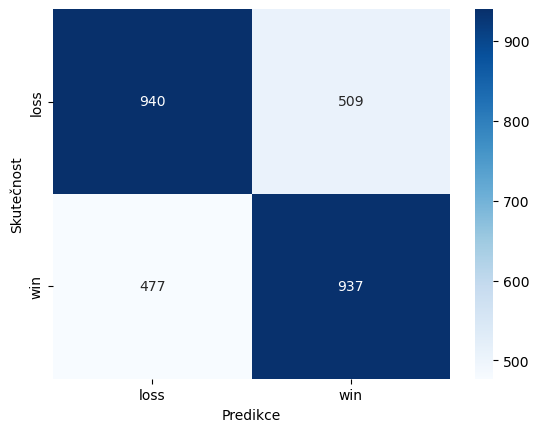

In [42]:
confusion_matrix_plot(Y_test,yhat)

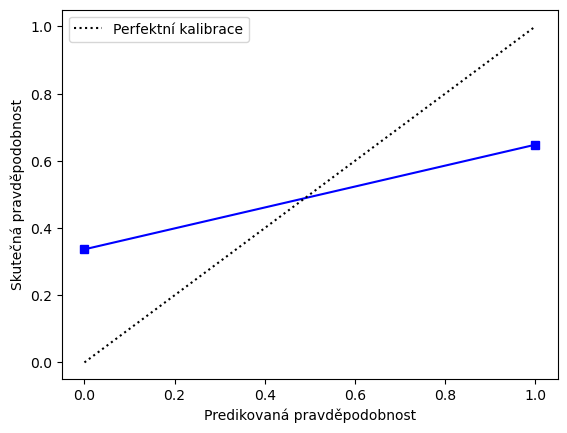

In [43]:
prob_true, prob_pred = calibration_curve(
  Y_test,
  yhat,
  n_bins=10
)
plt.plot(prob_pred, prob_true, marker='s', color='b')
plt.plot([0, 1], [0, 1], label="Perfektní kalibrace", ls=":", color='k')
plt.xlabel("Predikovaná pravděpodobnost")
plt.ylabel("Skutečná pravděpodobnost")
plt.legend()

### SVM

In [44]:
parameters = {'kernel':['linear'],
             "C": [0.00001, 0.001, 0.1]}
svm = SVC()

svm_cv = GridSearchCV(svm, cv=3, param_grid=parameters, n_jobs=-1)
svm_cv.fit(X_train, Y_train)

GridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [1e-05, 0.001, 0.1], 'kernel': ['linear']})

In [45]:
print("best parameters: ",svm_cv.best_params_)

best parameters:  {'C': 0.001, 'kernel': 'linear'}


In [46]:
yhat=svm_cv.predict(X_test)
print(classification_report(Y_test, yhat, digits=3))

accuracy = accuracy_score(Y_test,yhat)
precision = precision_score(Y_test,yhat, average=None)
recall = recall_score(Y_test,yhat, average=None)
f1 = f1_score(Y_test,yhat, average=None)
precision_w = precision_score(Y_test,yhat, average="weighted")
recall_w = recall_score(Y_test,yhat, average="weighted")
f1_w = f1_score(Y_test,yhat, average="weighted")

print("Accuracy:", accuracy)
print("Precision:", precision, "Weighted Avg:", precision_w)
print("Recall:", recall, "Weighted Avg:", recall_w)
print("F1-score:", f1, "Weighted Avg:", f1_w)

              precision    recall  f1-score   support

           0      0.676     0.611     0.642      1449
           1      0.637     0.700     0.667      1414

    accuracy                          0.655      2863
   macro avg      0.657     0.656     0.655      2863
weighted avg      0.657     0.655     0.655      2863

Accuracy: 0.6552567237163814
Precision: [0.67633588 0.63747585] Weighted Avg: 0.6571433962381611
Recall: [0.61145618 0.70014144] Weighted Avg: 0.6552567237163814
F1-score: [0.64226169 0.66734075] Weighted Avg: 0.6546479236411848


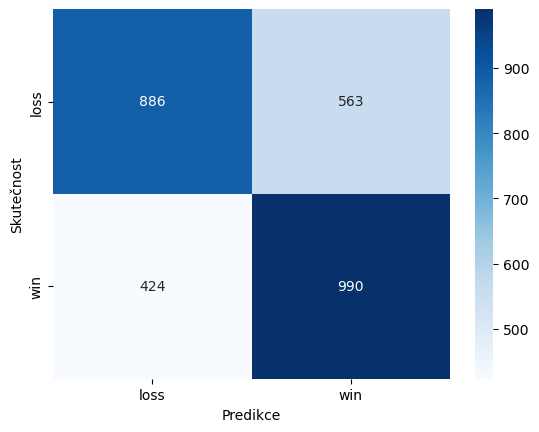

In [47]:
confusion_matrix_plot(Y_test,yhat)

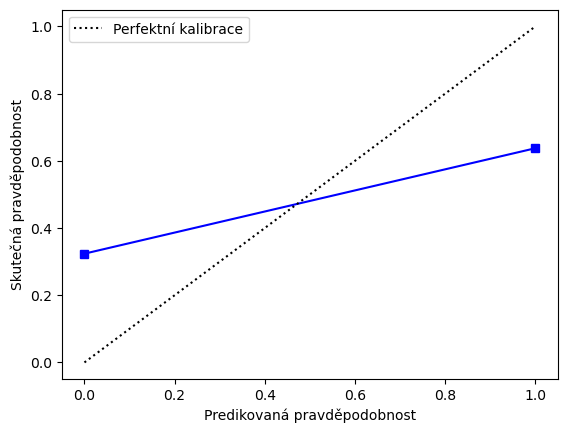

In [48]:
prob_true, prob_pred = calibration_curve(
  Y_test,
  yhat,
  n_bins=10
)
plt.plot(prob_pred, prob_true, marker='s', color='b')
plt.plot([0, 1], [0, 1], label="Perfektní kalibrace", ls=":", color='k')
plt.xlabel("Predikovaná pravděpodobnost")
plt.ylabel("Skutečná pravděpodobnost")
plt.legend()

### Decision Tree

In [49]:
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [8, 16, 24, 48],
     'max_features': ['log2', 'sqrt'],
     'min_samples_leaf': [ 2, 4, 8, 12],
     'min_samples_split': [2, 3, 5],
    'class_weight': [None, 'balanced'],
    'random_state': [21]}

tree = DecisionTreeClassifier()
tree_cv = GridSearchCV(tree, cv=5, param_grid=parameters, n_jobs=-1)
tree_cv.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': [None, 'balanced'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [8, 16, 24, 48],
                         'max_features': ['log2', 'sqrt'],
                         'min_samples_leaf': [2, 4, 8, 12],
                         'min_samples_split': [2, 3, 5], 'random_state': [21],
                         'splitter': ['best', 'random']})

In [50]:
print("best parameters: ",tree_cv.best_params_)

best parameters:  {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 24, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'random_state': 21, 'splitter': 'random'}


In [51]:
yhat=tree_cv.predict(X_test)
print(classification_report(Y_test, yhat, digits=3))

accuracy = accuracy_score(Y_test,yhat)
precision = precision_score(Y_test,yhat, average=None)
recall = recall_score(Y_test,yhat, average=None)
f1 = f1_score(Y_test,yhat, average=None)
precision_w = precision_score(Y_test,yhat, average="weighted")
recall_w = recall_score(Y_test,yhat, average="weighted")
f1_w = f1_score(Y_test,yhat, average="weighted")

print("Accuracy:", accuracy)
print("Precision:", precision, "Weighted Avg:", precision_w)
print("Recall:", recall, "Weighted Avg:", recall_w)
print("F1-score:", f1, "Weighted Avg:", f1_w)

              precision    recall  f1-score   support

           0      0.647     0.651     0.649      1449
           1      0.641     0.636     0.639      1414

    accuracy                          0.644      2863
   macro avg      0.644     0.644     0.644      2863
weighted avg      0.644     0.644     0.644      2863

Accuracy: 0.6440796367446734
Precision: [0.64746228 0.6405694 ] Weighted Avg: 0.6440579685858656
Recall: [0.65148378 0.63649222] Weighted Avg: 0.6440796367446734
F1-score: [0.6494668 0.6385243] Weighted Avg: 0.6440624375578384


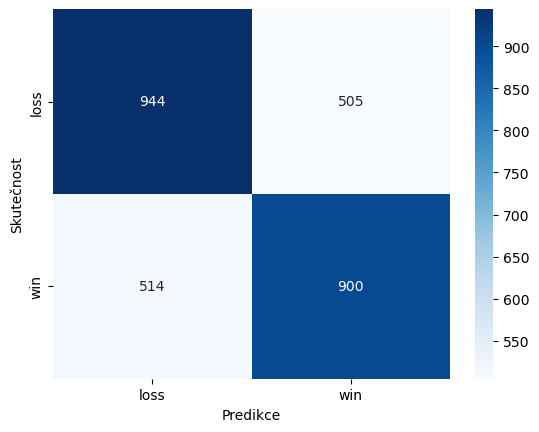

In [52]:
confusion_matrix_plot(Y_test,yhat)

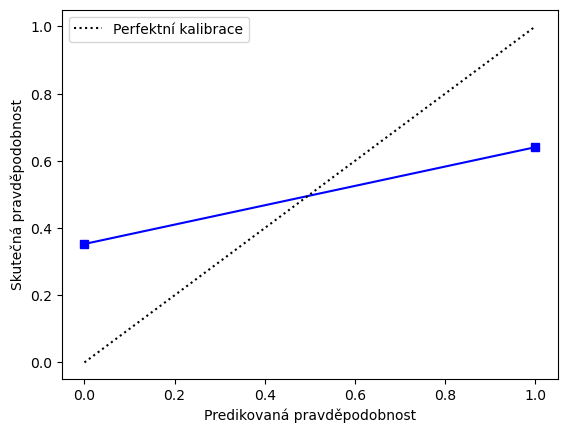

In [53]:
prob_true, prob_pred = calibration_curve(
  Y_test,
  yhat,
  n_bins=10
)
plt.plot(prob_pred, prob_true, marker='s', color='b')
plt.plot([0, 1], [0, 1], label="Perfektní kalibrace", ls=":", color='k')
plt.xlabel("Predikovaná pravděpodobnost")
plt.ylabel("Skutečná pravděpodobnost")
plt.legend()

## KNN

In [54]:
parameters = {'n_neighbors': [10, 150, 300, 500],
              'algorithm': ['auto'],
              'p': [1,2],
              'metric':['minkowski', 'euclidean', 'manhattan']}

KNN = KNeighborsClassifier()
knn_cv=GridSearchCV(KNN, cv=5, param_grid=parameters, n_jobs=-1)
knn_cv.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'algorithm': ['auto'],
                         'metric': ['minkowski', 'euclidean', 'manhattan'],
                         'n_neighbors': [10, 150, 300, 500], 'p': [1, 2]})

In [55]:
print("best parameters: ",knn_cv.best_params_)

best parameters:  {'algorithm': 'auto', 'metric': 'minkowski', 'n_neighbors': 300, 'p': 2}


In [56]:
yhat=knn_cv.predict(X_test)
print(classification_report(Y_test, yhat, digits=3))

accuracy = accuracy_score(Y_test,yhat)
precision = precision_score(Y_test,yhat, average=None)
recall = recall_score(Y_test,yhat, average=None)
f1 = f1_score(Y_test,yhat, average=None)
precision_w = precision_score(Y_test,yhat, average="weighted")
recall_w = recall_score(Y_test,yhat, average="weighted")
f1_w = f1_score(Y_test,yhat, average="weighted")

print("Accuracy:", accuracy)
print("Precision:", precision, "Weighted Avg:", precision_w)
print("Recall:", recall, "Weighted Avg:", recall_w)
print("F1-score:", f1, "Weighted Avg:", f1_w)

              precision    recall  f1-score   support

           0      0.662     0.642     0.652      1449
           1      0.644     0.665     0.654      1414

    accuracy                          0.653      2863
   macro avg      0.653     0.653     0.653      2863
weighted avg      0.653     0.653     0.653      2863

Accuracy: 0.6531610199091862
Precision: [0.66239316 0.6442769 ] Weighted Avg: 0.6534457672784657
Recall: [0.64182195 0.66478076] Weighted Avg: 0.6531610199091862
F1-score: [0.65194532 0.65436826] Weighted Avg: 0.6531419783276559


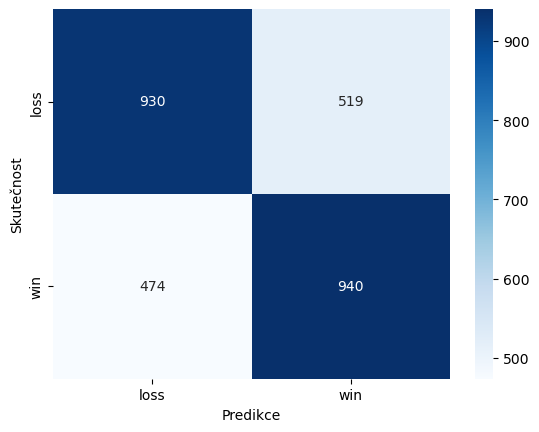

In [57]:
confusion_matrix_plot(Y_test,yhat)

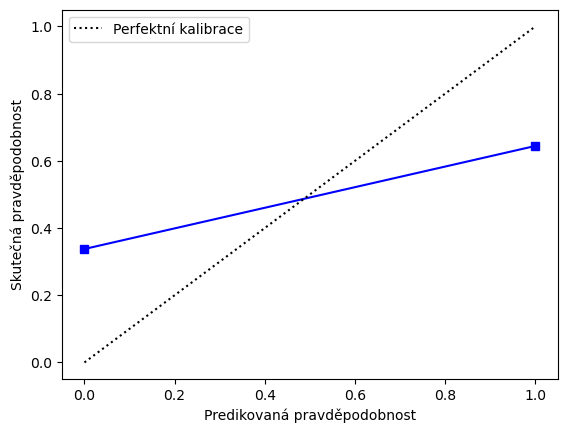

In [58]:
prob_true, prob_pred = calibration_curve(
  Y_test,
  yhat,
  n_bins=10
)
plt.plot(prob_pred, prob_true, marker='s', color='b')
plt.plot([0, 1], [0, 1], label="Perfektní kalibrace", ls=":", color='k')
plt.xlabel("Predikovaná pravděpodobnost")
plt.ylabel("Skutečná pravděpodobnost")
plt.legend()

## Random Forest

In [59]:
parameters = {
    'n_estimators': [300],  # Number of trees in the forest
    'criterion': ['gini', 'entropy'],  # Split criterion
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4],}

forest = RandomForestClassifier()
forest_cv = GridSearchCV(forest, cv=5, param_grid=parameters, n_jobs=-1)
forest_cv.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 15],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [300]})

In [60]:
print("best parameters: ",forest_cv.best_params_)

best parameters:  {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}


In [61]:
yhat=forest_cv.predict(X_test)
print(classification_report(Y_test, yhat, digits=3))

accuracy = accuracy_score(Y_test,yhat)
precision = precision_score(Y_test,yhat, average=None)
recall = recall_score(Y_test,yhat, average=None)
f1 = f1_score(Y_test,yhat, average=None)
precision_w = precision_score(Y_test,yhat, average="weighted")
recall_w = recall_score(Y_test,yhat, average="weighted")
f1_w = f1_score(Y_test,yhat, average="weighted")

print("Accuracy:", accuracy)
print("Precision:", precision, "Weighted Avg:", precision_w)
print("Recall:", recall, "Weighted Avg:", recall_w)
print("F1-score:", f1, "Weighted Avg:", f1_w)

              precision    recall  f1-score   support

           0      0.681     0.635     0.657      1449
           1      0.650     0.695     0.672      1414

    accuracy                          0.665      2863
   macro avg      0.666     0.665     0.665      2863
weighted avg      0.666     0.665     0.664      2863

Accuracy: 0.66468739084876
Precision: [0.68097705 0.65013228] Weighted Avg: 0.6657432023515102
Recall: [0.63492063 0.69519095] Weighted Avg: 0.66468739084876
F1-score: [0.65714286 0.67190704] Weighted Avg: 0.6644347031169835


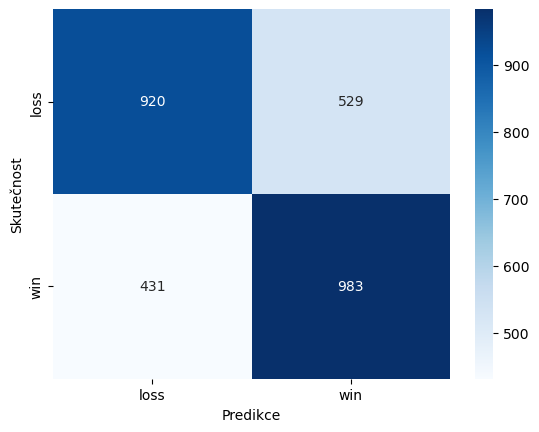

In [62]:
confusion_matrix_plot(Y_test,yhat)

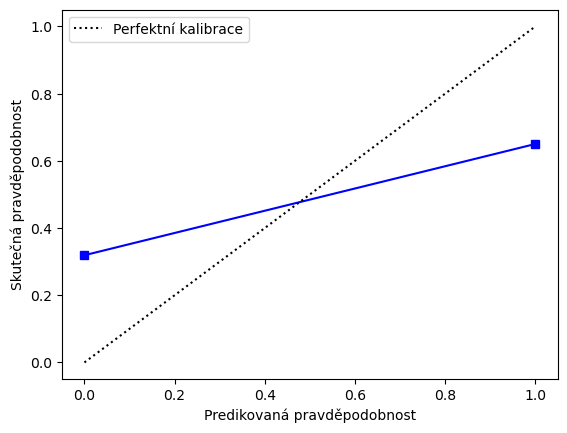

In [63]:
prob_true, prob_pred = calibration_curve(
  Y_test,
  yhat,
  n_bins=10
)
plt.plot(prob_pred, prob_true, marker='s', color='b')
plt.plot([0, 1], [0, 1], label="Perfektní kalibrace", ls=":", color='k')
plt.xlabel("Predikovaná pravděpodobnost")
plt.ylabel("Skutečná pravděpodobnost")
plt.legend()

## Model Comparison

In [64]:
#models = pd.DataFrame(data={"Model":["Logistic Regression", "SVM", "Decision Tree", "KNN", "Random Forest"], "Score":[lr_score, svm_score, tree_score, knn_score, forest_score]})

In [65]:
"""
sns.barplot(x="Model", y="Score", data=models)
plt.ylim(0,1)
plt.title("Comparision of prediction models")
"""

'\nsns.barplot(x="Model", y="Score", data=models)\nplt.ylim(0,1)\nplt.title("Comparision of prediction models")\n'

# Method prediction

In [66]:
ufc_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14588 entries, 0 to 14587
Data columns (total 68 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Fighter A       14588 non-null  object 
 1   Fighter B       14588 non-null  object 
 2   Result          14588 non-null  object 
 3   Weightclass     14588 non-null  float64
 4   Rounds          14588 non-null  int64  
 5   Venue           14588 non-null  object 
 6   Date            14588 non-null  object 
 7   Location        14588 non-null  object 
 8   Billing         14588 non-null  object 
 9   Event Name      14588 non-null  object 
 10  Referee         14384 non-null  object 
 11  Description     14530 non-null  object 
 12  Method          14588 non-null  object 
 13  Finish          14588 non-null  int64  
 14  Odds A          14588 non-null  int64  
 15  Title A         14588 non-null  object 
 16  Weight A        14588 non-null  float64
 17  Age A           14588 non-null 

In [67]:
ufc_multi = ufc_combined[["Result", "Method","Weightclass","Rounds", "Venue", "Date", "Title A", "Title B","Odds A", "Odds B", "Odds cat A", "Odds cat B","Nationality A", "Nationality B","Weight Miss A","Weight Miss B","Age Diff","Height Diff","Reach Diff","KO win Diff","KO loss Diff","Sub win Diff","Sub loss Diff","Dec win Diff","Dec loss Diff","Draws Diff","UFC win Diff","UFC loss Diff","UFC draws Diff"]]

We have to change the "Venue" column as we did in ufc_analysis ("UFC Apex" and other).  

In [68]:
ufc_multi.loc[~ufc_multi["Venue"].isin(["UFC Apex", "UFC APEX"]), "Venue"] = 0
ufc_multi.loc[ufc_multi["Venue"].isin(["UFC Apex", "UFC APEX"]), "Venue"] = 1

We only use year out of date.

In [69]:
year = []
def get_year():
    for date in ufc_multi["Date"]:
        year.append(date.split("-")[0])
    return year
get_year()
ufc_multi['Year'] = year
ufc_multi.head()

C:\Users\Uživatel\AppData\Local\Temp\ipykernel_4284\4240274640.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ufc_multi['Year'] = year


,Result,Method,Weightclass,Rounds,Venue,Date,Title A,Title B,Odds A,Odds B,Odds cat A,Odds cat B,Nationality A,Nationality B,Weight Miss A,Weight Miss B,Age Diff,Height Diff,Reach Diff,KO win Diff,KO loss Diff,Sub win Diff,Sub loss Diff,Dec win Diff,Dec loss Diff,Draws Diff,UFC win Diff,UFC loss Diff,UFC draws Diff,Year
0,win,Submission,265.0,5,1,2024-03-16,No,No,-105,-115,Near Even,Near Even,Poland,Australia,False,False,7,3.0,7.0,-4,2,6,-2,8,2,0,3,1,0,2024
1,NC,No Contest,170.0,3,1,2024-03-16,No,No,-180,150,Slight Favorite,Slight Underdog,United States,"Congo, The Democratic Republic of the",False,False,0,7.0,8.0,-2,0,4,1,-2,-2,0,3,0,0,2024
2,win,Decision,205.0,3,1,2024-03-16,No,No,500,-700,Heavy Underdog,Huge Favorite,United States,United States,False,False,9,-5.0,-8.0,4,3,7,2,3,8,0,8,8,0,2024
3,win,Decision,145.0,3,1,2024-03-16,No,No,165,-200,Slight Underdog,Moderate Favorite,United States,United States,False,False,-1,0.0,0.0,-1,0,2,0,3,1,0,2,1,0,2024
4,win,Submission,135.0,3,1,2024-03-16,No,No,-230,190,Moderate Favorite,Slight Underdog,United States,Sweden,False,False,0,10.0,15.0,-1,0,2,-1,-9,-3,0,1,-1,0,2024


In [70]:
ufc_multi = ufc_multi[ufc_multi["Result"] != "NC"]

In [71]:
ufc_multi.head()

,Result,Method,Weightclass,Rounds,Venue,Date,Title A,Title B,Odds A,Odds B,Odds cat A,Odds cat B,Nationality A,Nationality B,Weight Miss A,Weight Miss B,Age Diff,Height Diff,Reach Diff,KO win Diff,KO loss Diff,Sub win Diff,Sub loss Diff,Dec win Diff,Dec loss Diff,Draws Diff,UFC win Diff,UFC loss Diff,UFC draws Diff,Year
0,win,Submission,265.0,5,1,2024-03-16,No,No,-105,-115,Near Even,Near Even,Poland,Australia,False,False,7,3.0,7.0,-4,2,6,-2,8,2,0,3,1,0,2024
2,win,Decision,205.0,3,1,2024-03-16,No,No,500,-700,Heavy Underdog,Huge Favorite,United States,United States,False,False,9,-5.0,-8.0,4,3,7,2,3,8,0,8,8,0,2024
3,win,Decision,145.0,3,1,2024-03-16,No,No,165,-200,Slight Underdog,Moderate Favorite,United States,United States,False,False,-1,0.0,0.0,-1,0,2,0,3,1,0,2,1,0,2024
4,win,Submission,135.0,3,1,2024-03-16,No,No,-230,190,Moderate Favorite,Slight Underdog,United States,Sweden,False,False,0,10.0,15.0,-1,0,2,-1,-9,-3,0,1,-1,0,2024
5,win,Submission,185.0,3,1,2024-03-16,No,No,-250,200,Moderate Favorite,Moderate Underdog,United States,United States,False,False,2,2.0,14.0,-5,2,25,5,-3,-1,0,1,0,0,2024


In [72]:
# Instantiate the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the column to integer values
ufc_multi["Method"] = label_encoder.fit_transform(ufc_multi["Method"])

In [73]:
ufc_multi.head()

,Result,Method,Weightclass,Rounds,Venue,Date,Title A,Title B,Odds A,Odds B,Odds cat A,Odds cat B,Nationality A,Nationality B,Weight Miss A,Weight Miss B,Age Diff,Height Diff,Reach Diff,KO win Diff,KO loss Diff,Sub win Diff,Sub loss Diff,Dec win Diff,Dec loss Diff,Draws Diff,UFC win Diff,UFC loss Diff,UFC draws Diff,Year
0,win,2,265.0,5,1,2024-03-16,No,No,-105,-115,Near Even,Near Even,Poland,Australia,False,False,7,3.0,7.0,-4,2,6,-2,8,2,0,3,1,0,2024
2,win,0,205.0,3,1,2024-03-16,No,No,500,-700,Heavy Underdog,Huge Favorite,United States,United States,False,False,9,-5.0,-8.0,4,3,7,2,3,8,0,8,8,0,2024
3,win,0,145.0,3,1,2024-03-16,No,No,165,-200,Slight Underdog,Moderate Favorite,United States,United States,False,False,-1,0.0,0.0,-1,0,2,0,3,1,0,2,1,0,2024
4,win,2,135.0,3,1,2024-03-16,No,No,-230,190,Moderate Favorite,Slight Underdog,United States,Sweden,False,False,0,10.0,15.0,-1,0,2,-1,-9,-3,0,1,-1,0,2024
5,win,2,185.0,3,1,2024-03-16,No,No,-250,200,Moderate Favorite,Moderate Underdog,United States,United States,False,False,2,2.0,14.0,-5,2,25,5,-3,-1,0,1,0,0,2024


In [74]:
labels = label_encoder.classes_
labels

array(['Decision', 'KO/TKO', 'Submission'], dtype=object)

In [75]:
ufc_multi["Venue"] = ufc_multi["Venue"].astype(bool)
ufc_multi["Year"] = ufc_multi["Year"].astype(int)

In [76]:
multi = ufc_multi["Method"]
ufc_multi.drop(["Result", "Method", "Date"], axis=1, inplace = True)

In [77]:
def confusion_matrix_plot_multi(y,y_pred):
    cm = confusion_matrix(y, y_pred)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='.0f', cmap="Blues", ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predikce')
    ax.set_ylabel('Skutečnost')
    #ax.set_title('Confusion Matrix') 
    ax.xaxis.set_ticklabels(['Decision', 'KO/TKO', 'Submission'], rotation = 60)
    ax.yaxis.set_ticklabels(['Decision', 'KO/TKO', 'Submission'], rotation = 60) 
    plt.show() 

In [78]:
dummy = pd.get_dummies(ufc_multi)
dummy = dummy.astype(float)

In [79]:
multi = multi.astype(int)

In [80]:
Y = multi.to_numpy()

In [81]:
transform = preprocessing.StandardScaler()
X = transform.fit_transform(dummy)

In [82]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size= 0.2, random_state=3)

## Logistic Regression

In [83]:
parameters = {'C': [0.0001, 0.001, 1],'penalty': ['l2'], 'solver':['liblinear','lbfgs','newton-cg','sag','saga'], 
              'class_weight': [{0: 1, 1: 1.45, 2: 2.4}]
             }
lr = LogisticRegression(max_iter=1000)
lr_cv = GridSearchCV(lr, cv=5, param_grid=parameters, n_jobs=-1)
lr_cv.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 1],
                         'class_weight': [{0: 1, 1: 1.45, 2: 2.4}],
                         'penalty': ['l2'],
                         'solver': ['liblinear', 'lbfgs', 'newton-cg', 'sag',
                                    'saga']})

In [84]:
print("best parameters: ",lr_cv.best_params_)

best parameters:  {'C': 0.0001, 'class_weight': {0: 1, 1: 1.45, 2: 2.4}, 'penalty': 'l2', 'solver': 'liblinear'}


In [85]:
yhat=lr_cv.predict(X_test)
print(classification_report(Y_test, yhat, digits=3))

accuracy = accuracy_score(Y_test,yhat)
precision = precision_score(Y_test,yhat, average=None)
recall = recall_score(Y_test,yhat, average=None)
f1 = f1_score(Y_test,yhat, average=None)
precision_w = precision_score(Y_test,yhat, average="weighted")
recall_w = recall_score(Y_test,yhat, average="weighted")
f1_w = f1_score(Y_test,yhat, average="weighted")

print("Accuracy:", accuracy)
print("Precision:", precision, "Weighted Avg:", precision_w)
print("Recall:", recall, "Weighted Avg:", recall_w)
print("F1-score:", f1, "Weighted Avg:", f1_w)

              precision    recall  f1-score   support

           0      0.522     0.685     0.593      1372
           1      0.421     0.378     0.398       932
           2      0.231     0.098     0.138       580

    accuracy                          0.468      2884
   macro avg      0.391     0.387     0.376      2884
weighted avg      0.431     0.468     0.438      2884

Accuracy: 0.46775312066574204
Precision: [0.52222222 0.42054958 0.23076923] Weighted Avg: 0.4307514746913432
Recall: [0.6851312  0.3776824  0.09827586] Weighted Avg: 0.46775312066574204
F1-score: [0.592686   0.39796495 0.13784764] Weighted Avg: 0.43828715779618665


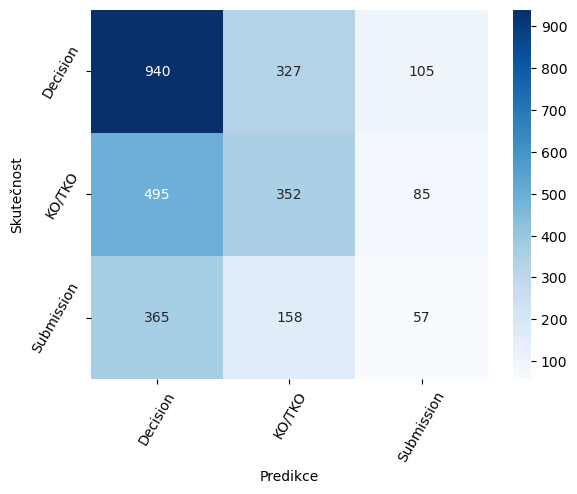

In [86]:
confusion_matrix_plot_multi(Y_test,yhat)

## SVM

In [87]:
parameters = {"C":[0.001],'kernel':['linear']
              , 'class_weight': [{0: 1, 1: 1.45, 2: 2.4}]
             }
svm = SVC()

svm_cv = GridSearchCV(svm, cv=3, param_grid=parameters, n_jobs=-1)
svm_cv.fit(X_train, Y_train)

GridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.001],
                         'class_weight': [{0: 1, 1: 1.45, 2: 2.4}],
                         'kernel': ['linear']})

In [88]:
print("best parameters: ",svm_cv.best_params_)

best parameters:  {'C': 0.001, 'class_weight': {0: 1, 1: 1.45, 2: 2.4}, 'kernel': 'linear'}


In [89]:
yhat=svm_cv.predict(X_test)
print(classification_report(Y_test, yhat, digits=3))

accuracy = accuracy_score(Y_test,yhat)
precision = precision_score(Y_test,yhat, average=None)
recall = recall_score(Y_test,yhat, average=None)
f1 = f1_score(Y_test,yhat, average=None)
precision_w = precision_score(Y_test,yhat, average="weighted")
recall_w = recall_score(Y_test,yhat, average="weighted")
f1_w = f1_score(Y_test,yhat, average="weighted")

print("Accuracy:", accuracy)
print("Precision:", precision, "Weighted Avg:", precision_w)
print("Recall:", recall, "Weighted Avg:", recall_w)
print("F1-score:", f1, "Weighted Avg:", f1_w)

              precision    recall  f1-score   support

           0      0.534     0.629     0.578      1372
           1      0.457     0.297     0.360       932
           2      0.252     0.288     0.269       580

    accuracy                          0.453      2884
   macro avg      0.414     0.405     0.402      2884
weighted avg      0.453     0.453     0.445      2884

Accuracy: 0.45319001386962554
Precision: [0.53436533 0.45709571 0.25188537] Weighted Avg: 0.45258527796641207
Recall: [0.62900875 0.2972103  0.28793103] Weighted Avg: 0.45319001386962554
F1-score: [0.57783729 0.36020806 0.26870475] Weighted Avg: 0.44533822325081773


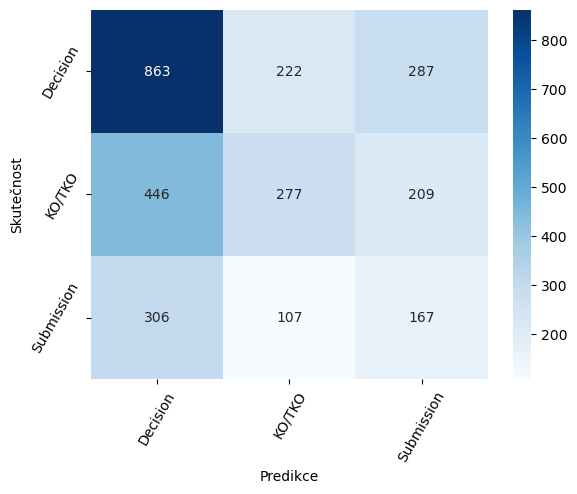

In [90]:
confusion_matrix_plot_multi(Y_test,yhat)

## Decision Tree

In [91]:
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [12, 16, 20],
     'max_features': ['log2', 'sqrt'],
     'min_samples_leaf': [ 6, 8, 10],
     'min_samples_split': [2, 3, 5],
    'class_weight': ['balanced', {0: 1, 1: 1.45, 2: 2.4}],
    'random_state': [21]}

tree = DecisionTreeClassifier()
tree_cv = GridSearchCV(tree, cv=5, param_grid=parameters, n_jobs=-1)
tree_cv.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced', {0: 1, 1: 1.45, 2: 2.4}],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [12, 16, 20],
                         'max_features': ['log2', 'sqrt'],
                         'min_samples_leaf': [6, 8, 10],
                         'min_samples_split': [2, 3, 5], 'random_state': [21],
                         'splitter': ['best', 'random']})

In [92]:
print("best parameters: ",tree_cv.best_params_)

best parameters:  {'class_weight': {0: 1, 1: 1.45, 2: 2.4}, 'criterion': 'entropy', 'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 2, 'random_state': 21, 'splitter': 'random'}


In [93]:
yhat=tree_cv.predict(X_test)
print(classification_report(Y_test, yhat, digits=3))

accuracy = accuracy_score(Y_test,yhat)
precision = precision_score(Y_test,yhat, average=None)
recall = recall_score(Y_test,yhat, average=None)
f1 = f1_score(Y_test,yhat, average=None)
precision_w = precision_score(Y_test,yhat, average="weighted")
recall_w = recall_score(Y_test,yhat, average="weighted")
f1_w = f1_score(Y_test,yhat, average="weighted")

print("Accuracy:", accuracy)
print("Precision:", precision, "Weighted Avg:", precision_w)
print("Recall:", recall, "Weighted Avg:", recall_w)
print("F1-score:", f1, "Weighted Avg:", f1_w)

              precision    recall  f1-score   support

           0      0.515     0.692     0.591      1372
           1      0.415     0.152     0.223       932
           2      0.242     0.291     0.265       580

    accuracy                          0.437      2884
   macro avg      0.391     0.379     0.359      2884
weighted avg      0.428     0.437     0.406      2884

Accuracy: 0.4372399445214979
Precision: [0.51490515 0.41520468 0.24246772] Weighted Avg: 0.42789594370095957
Recall: [0.69241983 0.15236052 0.29137931] Weighted Avg: 0.4372399445214979
F1-score: [0.59061237 0.22291994 0.26468285] Weighted Avg: 0.4062405023580779


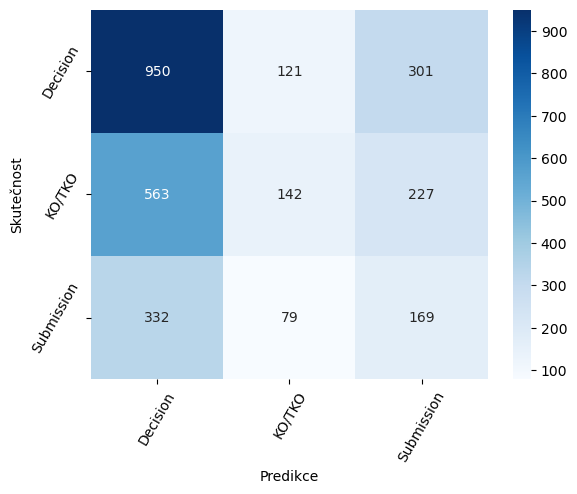

In [94]:
confusion_matrix_plot_multi(Y_test,yhat)

## KNN

In [95]:
parameters = {'n_neighbors': [10, 50, 100, 200, 300],
              'algorithm': ['auto'],
              'p': [1,2],
              'metric':['minkowski', 'euclidean', 'manhattan'],
             "weights":['distance']
             }

KNN = KNeighborsClassifier()
knn_cv=GridSearchCV(KNN, cv=10, param_grid=parameters, n_jobs=-1)
knn_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'algorithm': ['auto'],
                         'metric': ['minkowski', 'euclidean', 'manhattan'],
                         'n_neighbors': [10, 50, 100, 200, 300], 'p': [1, 2],
                         'weights': ['distance']})

In [96]:
print("best parameters: ",knn_cv.best_params_)

best parameters:  {'algorithm': 'auto', 'metric': 'minkowski', 'n_neighbors': 100, 'p': 1, 'weights': 'distance'}


In [97]:
yhat=knn_cv.predict(X_test)
print(classification_report(Y_test, yhat, digits=3))

accuracy = accuracy_score(Y_test,yhat)
precision = precision_score(Y_test,yhat, average=None)
recall = recall_score(Y_test,yhat, average=None)
f1 = f1_score(Y_test,yhat, average=None)
precision_w = precision_score(Y_test,yhat, average="weighted")
recall_w = recall_score(Y_test,yhat, average="weighted")
f1_w = f1_score(Y_test,yhat, average="weighted")

print("Accuracy:", accuracy)
print("Precision:", precision, "Weighted Avg:", precision_w)
print("Recall:", recall, "Weighted Avg:", recall_w)
print("F1-score:", f1, "Weighted Avg:", f1_w)

              precision    recall  f1-score   support

           0      0.503     0.901     0.646      1372
           1      0.484     0.222     0.304       932
           2      0.000     0.000     0.000       580

    accuracy                          0.500      2884
   macro avg      0.329     0.374     0.317      2884
weighted avg      0.396     0.500     0.406      2884

Accuracy: 0.5003467406380028
Precision: [0.50346232 0.48364486 0.        ] Weighted Avg: 0.395806974634111
Recall: [0.90087464 0.222103   0.        ] Weighted Avg: 0.5003467406380028
F1-score: [0.64593677 0.30441176 0.        ] Weighted Avg: 0.4056647040255086


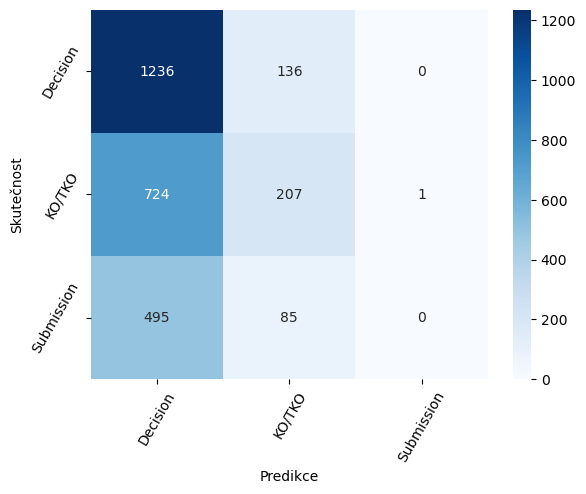

In [98]:
confusion_matrix_plot_multi(Y_test,yhat)

## Random Forest

In [99]:
parameters = {
    'n_estimators': [10, 30, 50, 100], 
    'criterion': ['gini', 'entropy'], 
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4],
    'class_weight': [{0: 1, 1: 1.45, 2: 2.45}]
}

forest = RandomForestClassifier()
forest_cv = GridSearchCV(forest, cv=5, param_grid=parameters, n_jobs=-1)
forest_cv.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'class_weight': [{0: 1, 1: 1.45, 2: 2.45}],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 15],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [10, 30, 50, 100]})

In [100]:
print("best parameters: ",forest_cv.best_params_)

best parameters:  {'class_weight': {0: 1, 1: 1.45, 2: 2.45}, 'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [101]:
yhat=forest_cv.predict(X_test)
print(classification_report(Y_test, yhat, digits=3))

accuracy = accuracy_score(Y_test,yhat)
precision = precision_score(Y_test,yhat, average=None)
recall = recall_score(Y_test,yhat, average=None)
f1 = f1_score(Y_test,yhat, average=None)
precision_w = precision_score(Y_test,yhat, average="weighted")
recall_w = recall_score(Y_test,yhat, average="weighted")
f1_w = f1_score(Y_test,yhat, average="weighted")

print("Accuracy:", accuracy)
print("Precision:", precision, "Weighted Avg:", precision_w)
print("Recall:", recall, "Weighted Avg:", recall_w)
print("F1-score:", f1, "Weighted Avg:", f1_w)

              precision    recall  f1-score   support

           0      0.547     0.629     0.585      1372
           1      0.440     0.448     0.444       932
           2      0.346     0.212     0.263       580

    accuracy                          0.487      2884
   macro avg      0.444     0.430     0.431      2884
weighted avg      0.472     0.487     0.475      2884

Accuracy: 0.4868238557558946
Precision: [0.5468948  0.43953733 0.34647887] Weighted Avg: 0.47189535634341323
Recall: [0.62900875 0.44849785 0.21206897] Weighted Avg: 0.4868238557558946
F1-score: [0.58508475 0.44397238 0.2631016 ] Weighted Avg: 0.47472866297331556


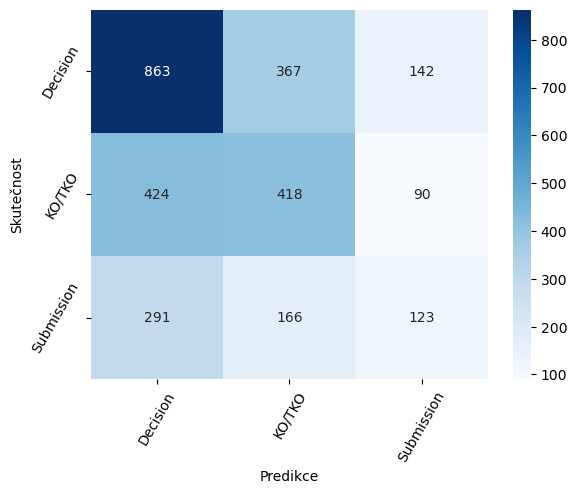

In [102]:
confusion_matrix_plot_multi(Y_test,yhat)

# Elo Model

In [106]:
from skelo.model.elo import EloEstimator

In [107]:
df = ufc_data[["Fighter A", "Fighter B", "Result", "Date"]]

In [108]:
df = df[df["Result"] != "NC"]
df = df[df["Result"] != "draw"]

In [109]:
df["Date"].min()

'2001-05-04'

In [110]:
df["Date"][1431]

'2021-06-12'

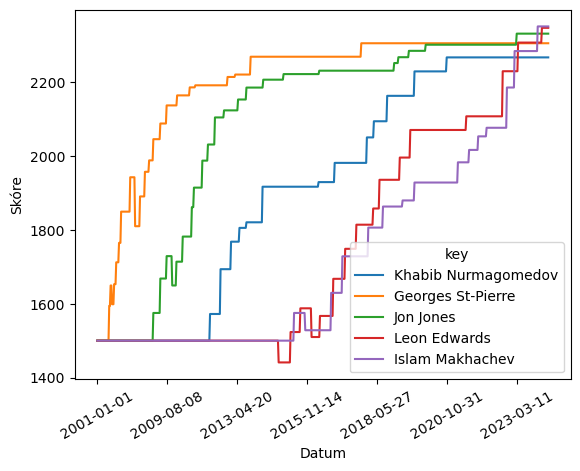

In [111]:
# For measuring classifier calibration linearity, it's better to have both true and false
# labels in the dataset, so we relabel the order of (winner, loser) to just be (player1, player2)
order_mask = (df["Fighter A"] < df["Fighter B"])
df["p1"] = ""
df["p2"] = ""
df["label"] = 1
df.loc[order_mask, "p1"] = df.loc[order_mask, "Fighter A"]
df.loc[~order_mask, "p1"] = df.loc[~order_mask, "Fighter B"]
df.loc[order_mask, "p2"] = df.loc[order_mask, "Fighter B"]
df.loc[~order_mask, "p2"] = df.loc[~order_mask, "Fighter A"]
df.loc[~order_mask, "label"] = 0

player_counts = pd.concat([df["p1"], df["p2"]], axis=0).value_counts()
players = player_counts[player_counts > 0].index
mask = (df["p1"].isin(players) & df["p2"].isin(players))
X = df.loc[mask]

# Create a model to fit on a dataframe.
model = EloEstimator(
    default_k = 150,
    initial_value = 1500,
    key1_field="p1",
    key2_field="p2",
    timestamp_field='Date',
    initial_time='2001-01-01',
).fit(X, X["label"])

#  Retrieve the fitted Elo ratings from the model
ratings_est = model.rating_model.to_frame()
ts_est = ratings_est.pivot_table(index='valid_from', columns='key', values='rating').ffill()

idx = ts_est.iloc[-1].sort_values().index[-5:]
ts_est.loc[:, idx].plot()
plt.xticks(rotation=30)
plt.xlabel("Datum")
plt.ylabel("Skóre")
plt.show()

In [112]:
from sklearn.metrics import classification_report
mask = (X["Date"] > '2001-01-01')
print(classification_report(X.loc[mask, "label"], model.predict(X.loc[mask]), digits=3))

              precision    recall  f1-score   support

           0      0.562     0.609     0.585      3550
           1      0.581     0.533     0.556      3607

    accuracy                          0.571      7157
   macro avg      0.571     0.571     0.570      7157
weighted avg      0.572     0.571     0.570      7157



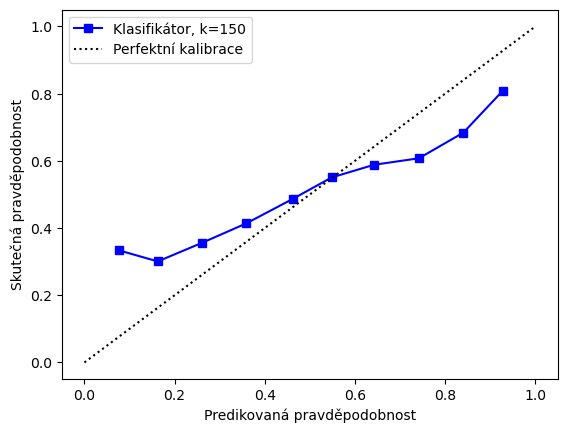

In [113]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(
  X.loc[mask, "label"],
  model.predict_proba(X.loc[mask]).values[:, 0],
  n_bins=10
)
plt.plot(prob_pred, prob_true, label=f"Klasifikátor, k={model.rating_model.default_k}", marker='s', color='b')
plt.plot([0, 1], [0, 1], label="Perfektní kalibrace", ls=":", color='k')
plt.xlabel("Predikovaná pravděpodobnost")
plt.ylabel("Skutečná pravděpodobnost")
plt.legend()

In [114]:
X = X.reset_index()
X.drop("index", axis=1, inplace=True)

In [115]:
clf = GridSearchCV(
  model,
  param_grid={
    'default_k': [
      10, 25, 50, 75, 100, 150, 200, 250, 300, 500, 750
    ]
  },
  cv=[(X.index, X.index[len(X)//2:])],
).fit(X, X['label'])

results = pd.DataFrame(clf.cv_results_)

In [116]:
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_default_k,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
0,0.046012,0.0,0.025511,0.0,10,{'default_k': 10},0.566918,0.566918,0.0,10
1,0.043010,0.0,0.025005,0.0,25,{'default_k': 25},0.567756,0.567756,0.0,9
2,0.042514,0.0,0.025006,0.0,50,{'default_k': 50},0.570830,0.570830,0.0,5
3,0.043011,0.0,0.025512,0.0,75,{'default_k': 75},0.574742,0.574742,0.0,4
4,0.043010,0.0,0.026007,0.0,100,{'default_k': 100},0.576139,0.576139,0.0,2
5,0.041514,0.0,0.024006,0.0,150,{'default_k': 150},0.576418,0.576418,0.0,1
6,0.043517,0.0,0.024007,0.0,200,{'default_k': 200},0.575021,0.575021,0.0,3
7,0.043010,0.0,0.024513,0.0,250,{'default_k': 250},0.568874,0.568874,0.0,6
8,0.043010,0.0,0.025006,0.0,300,{'default_k': 300},0.565521,0.565521,0.0,11
9,0.044517,0.0,0.025006,0.0,500,{'default_k': 500},0.568036,0.568036,0.0,8


In [117]:
yhat = model.predict(df)

In [118]:
yhat.value_counts()

pr1
0.0    3848
1.0    3309
Name: count, dtype: int64

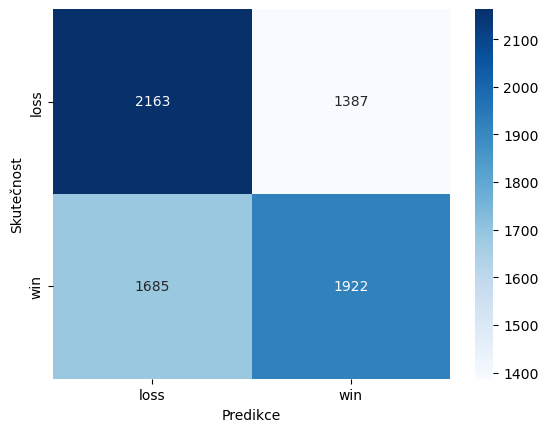

In [119]:
confusion_matrix_plot(df["label"], model.predict(df))